## Install Prerequisites

In [1]:
!pip install --upgrade pip
!pip install ipywidgets pyyaml plotly networkx networkx matplotlib scipy
!jupyter nbextension enable --py widgetsnbextension
!jupyter labextension install @jupyter-widgets/jupyterlab-manager
!jupyter lab build

     |████████████████████████████████| 1.5 MB 908 kB/s eta 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 20.3.1
    Uninstalling pip-20.3.1:
      Successfully uninstalled pip-20.3.1
     |████████████████████████████████| 121 kB 827 kB/s eta 0:00:01
     |████████████████████████████████| 662 kB 2.0 MB/s eta 0:00:01
     |████████████████████████████████| 20.6 MB 524 kB/s eta 0:00:01
     |████████████████████████████████| 1.6 MB 1.3 MB/s eta 0:00:01
     |████████████████████████████████| 10.3 MB 613 kB/s eta 0:00:01
     |████████████████████████████████| 28.4 MB 2.1 MB/s eta 0:00:01     |███████████▌                    | 10.2 MB 2.1 MB/s eta 0:00:09     |█████████████████████████▋      | 22.7 MB 1.8 MB/s eta 0:00:04     |██████████████████████████████▉ | 27.3 MB 1.7 MB/s eta 0:00:01
     |████████████████████████████████| 2.2 MB 1.9 MB/s eta 0:00:01
     |████████████████████████████████| 243 kB 1.8 MB/s eta 0:00:01
     |████████████████████████████████

In [5]:
import subprocess
import sys
import base64
import getpass
import requests
import yaml
import matplotlib
import plotly.graph_objects as go
import networkx as nx
import webbrowser

To be able to show the whigets run:
```
pip install --upgrade pip
pip install ipywidgets ipywidgets pyyaml plotly networkx networkx
!jupyter nbextension enable --py widgetsnbextension
jupyter nbextension enable --py widgetsnbextension
jupyter labextension install @jupyter-widgets/jupyterlab-manager
jupyter lab build
```
Close the Jupyter lab window and open it again 

# Client Configuration

In [6]:
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from ipywidgets import TwoByTwoLayout
from ipywidgets import AppLayout, Button, Layout


sdia_conf_url_widget =  widgets.Text(
    value='https://lifewatch.lab.uvalight.net:30003/orchestrator',
    placeholder='Enter SDIA API endpoint. e.g. https://lifewatch.lab.uvalight.net:30003/orchestrator',
    description='SDIA API URL:',
    disabled=False
)
sdia_conf_username_widget =  widgets.Text(
    value='notebook_user',
    placeholder='Enter SDIA username',
    description='SDIA username:',
    disabled=False
)

sdia_conf_token_widget =  widgets.Password(
    value='',
    placeholder='Enter your SDIA token',
    description='Password:',
    disabled=False
) 

sdia_conf_login_button = widgets.Button(
    description='Login',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Run report',
#     icon='check' # (FontAwesome names without the `fa-` prefix)
)

sdia_conf_output = widgets.Output()
sdia_conf_box = widgets.VBox([sdia_conf_url_widget, sdia_conf_username_widget, sdia_conf_token_widget, sdia_conf_login_button])
display(sdia_conf_box,sdia_conf_output)

# @sdia_conf_output.capture()
# def sdia_conf_on_button_clicked(b):
#     sdia_conf_url = sdia_conf_url_widget.value
# #     if not sdia_token_widget.value or not sdia_username_widget.value:
        

# sdia_conf_login_button.on_click(sdia_conf_on_button_clicked)



Output()

# Application Configuration

In [13]:
application_type_widget = widgets.Dropdown(
    options=['Helm'],
    value='Helm',
    description='Application Type:',
    disabled=False
)

application_type_output = widgets.Output()
application_type_box = widgets.VBox([application_type_widget])
display(application_type_box,application_type_output)

Output()

In [14]:
docker_app_image_name_widget =  widgets.Textarea(
    value='cloudcells/classifiers',
    placeholder='image name e.g. cloudcells/classifiers',
    description='Docker Image Name:',
    disabled=False
)

docker_app_image_ports_widget =  widgets.Textarea(
    value='',
    placeholder='the ports to expose e.g. 80',
    description='Ports:',
    disabled=False
)

enebale_monitoring_widget= widgets.Checkbox(
    value=True,
    description='Monitoring',
    disabled=False
)

app_name_widget =  widgets.Text(
    value='app',
    placeholder='the applications name',
    description='Application Name:',
    disabled=False
)

docker_app_box = widgets.VBox([app_name_widget,docker_app_image_name_widget, docker_app_image_ports_widget,enebale_monitoring_widget])

                    
helm_app_chart_name_widget =  widgets.Text(
    value='argo/argo',
    placeholder='the chart name e.g. argo/argo',
    description='Chart Name:',
    disabled=False
)


helm_app_repo_name_widget =  widgets.Text(
    value='argo',
    placeholder='the name of the repoitory name',
    description='Reposetory Name:',
    disabled=False
)

helm_app_repo_url_widget =  widgets.Text(
    value='https://argoproj.github.io/argo-helm',
    placeholder='the url',
    description='Reposetory URL:',
    disabled=False
)

helm_app_box = widgets.VBox([app_name_widget,helm_app_chart_name_widget, helm_app_repo_name_widget,helm_app_repo_url_widget,enebale_monitoring_widget])

app_conf_output = widgets.Output()

if application_type_widget.value == 'Docker':
    display(docker_app_box,app_conf_output)
elif application_type_widget.value == 'Helm':
    display(helm_app_box,app_conf_output)


Output()

# Infrastructure Configuration

## Number of Topologies
A topology is a set of VMs that will be provisined in the same location by the same provider.

In [15]:
num_of_topologies_widget= widgets.BoundedIntText(
    value=1,
    min=1,
    max=4,
    step=1,
    description='Num. Of Topologies:',
    disabled=False
)


topologies_output = widgets.Output()
number_of_topology_box = widgets.VBox([num_of_topologies_widget])
display(number_of_topology_box,topologies_output)


Output()

In [16]:
topologies_boxes = []
domain_names = ['East US','Central US','South Central US','West US','Australia East','Southeast Asia','UK South','West Europe','North Europe','South Africa North','Central India']


for i in range(0, num_of_topologies_widget.value):
    cloud_provider_name_widget = widgets.Dropdown(
        options=['EC2', 'Azure'],
        value='Azure',
        description='Cloud Provider:',
        name='cloud_provider_name',
        disabled=False
    )
    
    num_of_vms_widget= widgets.BoundedIntText(
        value=2,
        min=1,
        max=4,
        step=1,
        description='Num. Of VMs:',
        disabled=False
    )
    vm_size_name_widget = widgets.Dropdown(
        options=['small', 'medium','large'],
        value='medium',
        description='VM size:',
        disabled=False
    )
    topology_domain_widget = widgets.Dropdown(
        options=domain_names,
        value=domain_names[7],
        description='Topology Domain:',
        disabled=False
    )
    topology_box = widgets.VBox([cloud_provider_name_widget, num_of_vms_widget, vm_size_name_widget,topology_domain_widget])
    topologies_boxes.append(topology_box)

    
    
topologies_conf_tab = widgets.Tab()
topologies_conf_tab.children = topologies_boxes
for i in range(len(topologies_boxes)):
    topologies_conf_tab.set_title(i, 'topology_'+str(i+1))
    
    
topologies_conf_output = widgets.Output()
topologies_conf_tab_box = widgets.VBox([topologies_conf_tab])
display(topologies_conf_tab_box,topologies_conf_output)

Output()

## Generate TOSCA

In [57]:
import requests


def get_template(url):
    r = requests.get(url)
    with open('interface.yaml', 'wb') as f:
        f.write(r.content)

    with open('interface.yaml') as f:
        interface = yaml.safe_load(f)
    return interface
    
node_templates={}
app_prop = []

if application_type_widget.value == 'Docker':
    app_prop.append('Image Name: '+docker_app_image_name_widget.value)
    app_prop.append('Ports: '+docker_app_image_ports_widget.value)
elif application_type_widget.value == 'Helm':
    app_prop.append('Application Type: '+application_type_widget.value)
    app_prop.append('Chart name: '+helm_app_chart_name_widget.value)
    app_prop.append('Reposetory name: '+helm_app_repo_name_widget.value)
    app_prop.append('Reposetory URL: '+helm_app_repo_url_widget.value)

text = 'Application\n'
for line in app_prop:
    text += line+'\n'
    

def build_node_template(node_name=None,node_type=None,properties=None,requirements=None,interfaces=None):
    node_template = {node_name:{'properties':properties,'requirements':requirements,'interfaces':interfaces,'type':node_type}}
    return node_template
    
def translate_domain(cloud_provider,domain_name):
    if cloud_provider == 'Azure':
        return domain_name.lower().replace(' ','')
    
    
def translate_vm_size(cloud_provider,vm_size):
    vm_specs = {}
    if vm_size == 'small':
        vm_specs['num_cores']='1'
        vm_specs['mem_size']='2048 MB'
        vm_specs['disk_size']='10000 MB'
    elif vm_size == 'medium':
        vm_specs['num_cores']='2'
        vm_specs['mem_size']='4048 MB'
        vm_specs['disk_size']='20000 MB'
    elif vm_size == 'large':
        vm_specs['num_cores']='4'
        vm_specs['mem_size']='8048 MB'
        vm_specs['disk_size']='40000 MB'
    return vm_specs
    Generate
    
text += '\nInfrastructure\n'

def repalce_all(d,dict_value,value):
    for k, v in d.items():
        if isinstance(v, dict):
            repalce_all(v,dict_value,value)
        else:
            if v==dict_value:
                v = value
            if isinstance(v, list):
                v = [value if i==dict_value else i for i in v]

In [61]:


index=0
node_templates = {}
azure_topology_interface = get_template('https://raw.githubusercontent.com/qcdis-sdia/sdia-tosca/develop/templates/azure_topology_interface.yaml')
k8s_interface = get_template('https://raw.githubusercontent.com/qcdis-sdia/sdia-tosca/develop/templates/k8s_interface.yaml')
k8_requirements=[]
workflows = {}
for topology in topologies_boxes:
    index+=1
    topology_wiget_inputs={}
    topology_wiget_inputs['name'] = 'topology_'+str(index)
    for child in topology.children:
        text+=child.description+':'+str(child.value)+'\n'
        topology_wiget_inputs[child.description.replace(':','').replace(' ','_')]=child.value    
        
        
    topology_properties={}
    topology_properties['domain']=translate_domain(topology_wiget_inputs['Cloud_Provider'],topology_wiget_inputs['Topology_Domain'])
    topology_properties['provider'] = topology_wiget_inputs['Cloud_Provider']
    topology_requirements=[]
    
    for i in range(topology_wiget_inputs['Num._Of_VMs']):
        vm_name = 'compute_'+str(i)+'_'+topology_wiget_inputs['name']
        vm_properties = {'os_distro': 'Ubuntu','os_version':'18.04','user_name': 'vm_user'}
        vm_properties.update(translate_vm_size(topology_properties['provider'],topology_wiget_inputs['VM_size']))
        vm_interfaces={'Standard':{'create':'dumy.yaml'}}
        node_templates.update(build_node_template(node_name=vm_name,node_type='tosca.nodes.QC.VM.Compute',properties=vm_properties,interfaces=vm_interfaces))
        vm_req={'vm':{'capability': 'tosca.capabilities.QC.VM','node':vm_name ,'relationship':'tosca.relationships.DependsOn'}}
        topology_requirements.append(vm_req)
        instance_props =  {}
        for prop_name in ['user_name','user_name','os_version','disk_size','mem_size','num_cores','os_distro']:
            instance_props[prop_name] = { 'get_property': [ vm_name, prop_name ] }
        instances = {}
        instances[vm_name] = instance_props
        for interface_action_name in k8s_interface['Kubernetes']:
            inv_children = k8s_interface['Kubernetes'][interface_action_name]['inputs']['inventory']['all']['children']['cluster']['children']
            props={}
            props['ansible_host'] = { 'get_attribute': [ vm_name,'public_ip' ] }
            props['ansible_python_interpreter'] = '/usr/bin/python3'
            props['ansible_ssh_user'] = { 'get_property': [ vm_name,'user_name' ] }
            if i <=0:
                inv_children['master']['hosts']['m_0'] = props
            elif 'worker' in inv_children:
                host={'w_'+str(i):props}
                inv_children['worker']['hosts']= host
                
    azure_topology_interface = yaml.safe_load(yaml.dump(azure_topology_interface).replace('topology',topology_wiget_inputs['name']))    
    for interface_action_name in azure_topology_interface['Azure']:
        if 'instances' in azure_topology_interface['Azure'][interface_action_name]['inputs']['inventory']['all']['hosts']['localhost']:
            azure_topology_interface['Azure'][interface_action_name]['inputs']['inventory']['all']['hosts']['localhost']['instances'] = instances
            
    azure_workflows = get_template('https://raw.githubusercontent.com/qcdis-sdia/sdia-tosca/develop/templates/azure_prov_workflow.yaml')
    for workflow_name in azure_workflows:
        for step_name in azure_workflows[workflow_name]['steps']:
            azure_workflows[workflow_name]['steps'][step_name]['target'] = topology_wiget_inputs['name']
        if 'preconditions' in azure_workflows[workflow_name]:
            for preconditions in azure_workflows[workflow_name]['preconditions']:
                preconditions['target'] = topology_wiget_inputs['name']
        wf = {workflow_name+'_'+topology_wiget_inputs['name']:azure_workflows[workflow_name]}
        workflows.update(wf)
        
    k8s_workflows = get_template('https://raw.githubusercontent.com/qcdis-sdia/sdia-tosca/develop/templates/k8s_workflow.yaml')
    for workflow_name in k8s_workflows:
        for step_name in k8s_workflows[workflow_name]['steps']:
            k8s_workflows[workflow_name]['steps'][step_name]['target'] = 'kubernetes'
        if 'preconditions' in k8s_workflows[workflow_name]:
            for precondition in k8s_workflows[workflow_name]['preconditions']:
                if precondition['target'] == 'topology':
                    precondition['target'] = topology_wiget_inputs['name']
        wf = {workflow_name:k8s_workflows[workflow_name]}
        workflows.update(wf)


            
    k8_requirement={'host':{'capability': 'tosca.capabilities.QC.VM.topology','node':topology_wiget_inputs['name'] ,'relationship':'tosca.relationships.HostedOn'}}
    k8_requirements.append(k8_requirement)
    node_templates.update(build_node_template(node_name=topology_wiget_inputs['name'],node_type='tosca.nodes.QC.VM.topology',properties=topology_properties,requirements=topology_requirements,interfaces=azure_topology_interface))
    

In [62]:
vm_master_name = 'compute_'+str(0)+'_'+topology_wiget_inputs['name']
credential_properties = {'credential': { 'get_attribute': [ vm_master_name,'user_key_pair' ] }}        
ks8s_node = build_node_template(node_name='kubernetes',node_type='tosca.nodes.QC.docker.Orchestrator.Kubernetes',properties=credential_properties,requirements=k8_requirements,interfaces=k8s_interface)
node_templates.update(ks8s_node)

In [63]:
helm_req = {'kubernetes':{'capability': 'tosca.capabilities.QC.Kubernetes','node':'kubernetes' ,'relationship':'tosca.relationships.HostedOn'}}
helm_requirements = []
helm_requirements.append(helm_req)
helm_interface = get_template('https://raw.githubusercontent.com/qcdis-sdia/sdia-tosca/develop/templates/helm_interface.yaml')

ansible_vars = {}
ansible_vars['ansible_host']={ 'get_attribute': [ vm_master_name,'public_ip' ] }
ansible_vars['ansible_python_interpreter']= '/usr/bin/python3'
ansible_vars['ansible_ssh_user']= { 'get_property': [ vm_master_name,'user_name' ] }

for interface_action_name in helm_interface['Helm']:
    helm_interface['Helm'][interface_action_name]['inputs']['inventory']['all']['hosts']['master'] = ansible_vars
    
helm_workflow = get_template('https://raw.githubusercontent.com/qcdis-sdia/sdia-tosca/develop/templates/helm_workflow.yaml')
for workflow_name in helm_workflow:
    for step_name in helm_workflow[workflow_name]['steps']:
        if step_name != 'set_k8s_attributes':
            helm_workflow[workflow_name]['steps'][step_name]['target'] = app_name_widget.value
        else:
            helm_workflow[workflow_name]['steps'][step_name]['target'] = 'kubernetes'
    if 'preconditions' in helm_workflow[workflow_name]:
        for preconditions in helm_workflow[workflow_name]['preconditions']:
            if preconditions['target'] == 'kubernetes':
                preconditions['target'] = 'kubernetes'
            else:
                preconditions['target'] = app_name_widget.value
    wf = {workflow_name+'_'+app_name_widget.value:helm_workflow[workflow_name]}
    workflows.update(wf)
            
helm_interface['Helm']['install_chart']['inputs']['extra_variables']['chart_name'] = helm_app_chart_name_widget.value
helm_interface['Helm']['install_chart']['inputs']['extra_variables']['repo_name'] = helm_app_repo_name_widget.value
helm_interface['Helm']['install_chart']['inputs']['extra_variables']['repo_url'] = helm_app_repo_url_widget.value
helm_interface['Helm']['install_chart']['inputs']['extra_variables']['name'] = app_name_widget.value
node_templates.update(build_node_template(node_name=app_name_widget.value,node_type='tosca.nodes.QC.Container.Application.Helm',properties=credential_properties,requirements=helm_requirements,interfaces=helm_interface))

In [65]:
if enebale_monitoring_widget.value:
    helm_workflow = get_template('https://raw.githubusercontent.com/qcdis-sdia/sdia-tosca/develop/templates/helm_workflow.yaml')
    for workflow_name in helm_workflow:
        for step_name in helm_workflow[workflow_name]['steps']:
            if step_name != 'set_k8s_attributes':
                helm_workflow[workflow_name]['steps'][step_name]['target'] = 'monitoring'
            else:
                helm_workflow[workflow_name]['steps'][step_name]['target'] = 'kubernetes'
        if 'preconditions' in helm_workflow[workflow_name]:
            for preconditions in helm_workflow[workflow_name]['preconditions']:
                if preconditions['target'] == 'kubernetes':
                    preconditions['target'] = 'kubernetes'
                else:
                    preconditions['target'] = 'monitoring'
        wf = {workflow_name+'_monitoring':helm_workflow[workflow_name]}
        workflows.update(wf)
    
    node_templates.update(build_node_template(node_name='monitoring',node_type='tosca.nodes.QC.Container.Application.Helm',properties=credential_properties,requirements=helm_requirements,interfaces=helm_interface))
    


In [66]:
topology_template={}
topology_template['node_templates'] = node_templates
topology_template['workflows'] = workflows
tosca = {}
tosca['tosca_definitions_version'] = 'tosca_simple_yaml_1_2'
imports=[{'nodes':'https://raw.githubusercontent.com/qcdis-sdia/sdia-tosca/master/types/nodes.yaml','data':'https://raw.githubusercontent.com/qcdis-sdia/sdia-tosca/master/types/data.yml','capabilities':'https://raw.githubusercontent.com/qcdis-sdia/sdia-tosca/master/types/capabilities.yaml','policies':'https://raw.githubusercontent.com/qcdis-sdia/sdia-tosca/master/types/policies.yaml','interfaces':'https://raw.githubusercontent.com/qcdis-sdia/sdia-tosca/master/types/interfaces.yml'}]
tosca['imports'] = imports
repositories = {'docker_hub':'https://hub.docker.com/'}
tosca['repositories'] = repositories
tosca['topology_template'] = topology_template

class NoAliasDumper(yaml.Dumper):
    def ignore_aliases(self, data):
        return True
    
with open('generated_tosca.yaml', 'w') as file:
    yaml.dump(tosca, file,default_flow_style=False,Dumper=NoAliasDumper)

## Upload TOSCA

In [67]:
import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

base_url = sdia_conf_url_widget.value
username = sdia_conf_username_widget.value
password = sdia_conf_token_widget.value

path = "/tosca_template"
payload = {}
filename = 'generated_tosca.yaml'
fin = open(filename, 'rb')
files = {'file': fin}

headers = {}

response = requests.request("POST", base_url+path, headers=headers, files = files,verify=False,auth=(username, password))
tosca_id = response.text

## Show Topology

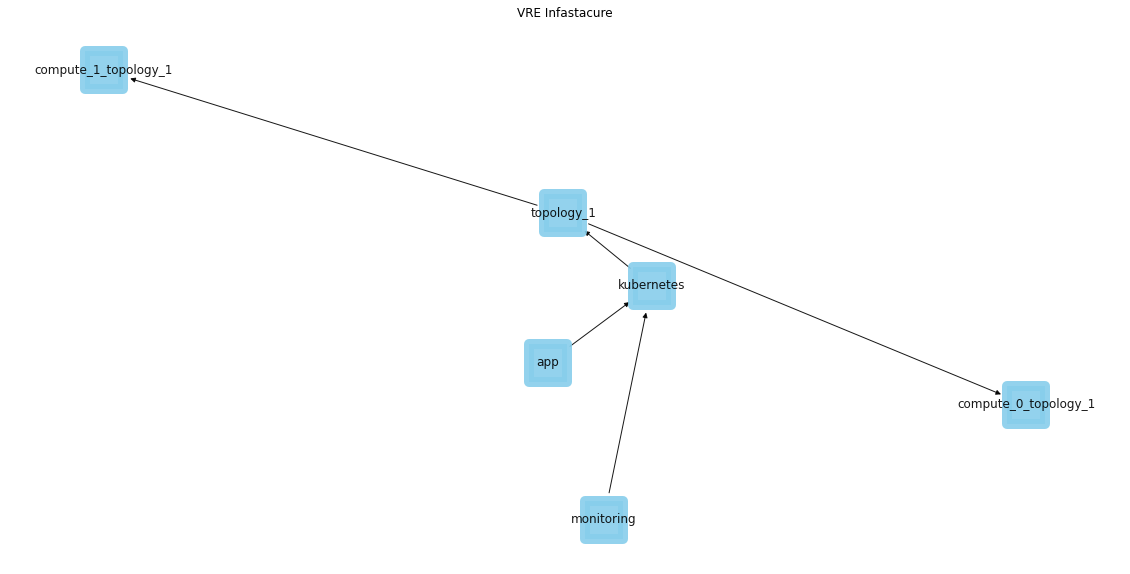

In [69]:
import networkx as nx
import random
import matplotlib.pyplot as plt



def build_graph(node_templates):
    graph = nx.DiGraph()
    for node_name in node_templates:
        graph.add_node(node_name, attr_dict=node_templates[node_name])
        if 'requirements' in node_templates[node_name]:
            for req in node_templates[node_name]['requirements']:
                req_name = next(iter(req))
                req_node_name = req[req_name]['node']
                if 'relationship' in req[req_name] and 'type' in req[req_name]['relationship']:
                    relationship_type = req[req_name]['relationship']['type']
                else:
                    if 'relationship' not in req[req_name]:
                        relationship_type = 'tosca.relationships.DependsOn'
                    else:
                        relationship_type = req[req_name]['relationship']
                graph.add_edge(node_name, req_node_name, relationship=relationship_type)

    # nx.draw(graph, with_labels=True)
    # plt.savefig("/tmp/graph.png")
    # plt.show()
    return graph




def get_tosca(tosca_id):
    path = "/tosca_template/"+tosca_id
    payload = {}
    headers= {'accept':'text/plain'}
    response = requests.request("GET", base_url+path, headers=headers, data = payload,verify=False, auth=(username, password))
    return response.text

tosca = get_tosca(tosca_id)
tosca_dict = yaml.safe_load(tosca)
graph = build_graph(tosca_dict['topology_template']['node_templates'])
# nx.draw(graph, with_labels=True)

fig, ax = plt.subplots(1, 1, figsize=(20, 10));
# nx.draw_networkx(graph, ax=ax,node_size=5000, node_color='#00b4d9')


nx.draw(graph, with_labels=True, node_size=1500, node_color="skyblue", node_shape="s", alpha=0.9, linewidths=10,pos=nx.spring_layout(graph))
plt.title("VRE Infastacure")
plt.show()





## Provision Plan

In [ ]:
path = "/provisioner/provision/"+tosca_id
payload = {}
headers= {'accept':'text/plain'}

response = requests.request("GET", base_url+path, headers=headers, data = payload,verify=False, auth=(username, password))
print(response.text)
provisioned_tosca_id = response.text

In [ ]:
tosca = get_tosca(provisioned_tosca_id)

tosca_dict = yaml.safe_load(tosca)
graph = build_graph(tosca_dict['topology_template']['node_templates'])
nx.draw(graph, with_labels=True)


for node_name in tosca_dict['topology_template']['node_templates']:
    if tosca_dict['topology_template']['node_templates'][node_name]['type'] == 'tosca.nodes.QC.VM.Compute':
        print(node_name+': '+tosca_dict['topology_template']['node_templates'][node_name]['attributes']['public_ip'])

## Deploy K8s And WS

In [ ]:
path = "/deployer/deploy/"+provisioned_tosca_id
payload = {}
headers= {'accept':'text/plain'}

response = requests.request("GET", base_url+path, headers=headers, data = payload, verify=False, auth=(username, password))
deployed_tosca_id = response.text

In [ ]:
tosca = get_tosca(deployed_tosca_id)

tosca_dict = yaml.safe_load(tosca)
graph = build_graph(tosca_dict['topology_template']['node_templates'])
nx.draw(graph, with_labels=True)

for node_name in tosca_dict['topology_template']['node_templates']:
    if tosca_dict['topology_template']['node_templates'][node_name]['type'] == 'tosca.nodes.QC.docker.Orchestrator.Kubernetes':
        for token in tosca_dict['topology_template']['node_templates'][node_name]['attributes']['tokens']:
            if token['user'] == 'dashboard_token':
                print(node_name+': '+' dashboard_token: '+token['token'])
        print(node_name+': '+str(tosca_dict['topology_template']['node_templates'][node_name]['attributes']['dashboard_url']))
    if tosca_dict['topology_template']['node_templates'][node_name]['type'] == 'tosca.nodes.QC.Container.Application.Docker':
        print(node_name+': '+str(tosca_dict['topology_template']['node_templates'][node_name]['attributes']['service_url']))
        